In [64]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import os
import Parameters as Para
para = Para.Parameters(data_size=192,predict_size=48,epochs=20,node_size=32,split_rate=0.6)
city = 'shanghai'

In [65]:
def get_correlation(a_list,b_list):
    return np.corrcoef(np.vstack((np.array(a_list),np.array(b_list))))

In [66]:
import getDataset as getDataset
input_data = list()
input_label = list()
# dataset_2016 = getDataset.GetDataset(year=2016, step=72, batch_size=64, data_size=data_size, predict_size=predict_size,split_rate=1)
dataset_2017 = getDataset.GetDataset(year=2017, step=48, batch_size=64, data_size=para.data_size, predict_size=para.predict_size,split_rate=1,city=city)
main_dataset = getDataset.GetDataset(year=2018, step=48, batch_size=64, data_size=para.data_size, predict_size=para.predict_size,split_rate=para.split_rate,city=city)
# data_mean_16, data_std_16 = train_dataset_2016.get_mean_std()
data_mean_17, data_std_17 = dataset_2017.get_mean_std()
data_mean, data_std = main_dataset.get_mean_std()
print(data_mean,data_std)

35.96626420454545 28.853002002441322


In [67]:
# for data1, data2 in dataset_2016.train_dataset():
#     for var in data1:
#         input_data.append(var)
#     for var in data2:
#         input_label.append(var*data_std_16+data_mean_16)      
for data1, data2 in dataset_2017.train_dataset():
    for var in data1:
        input_data.append(var)
    for var in data2:
        input_label.append(var*data_std_17+data_mean_17)         
for data1, data2 in main_dataset.train_dataset():
    for var in data1:
        input_data.append(var)
    for var in data2:
        input_label.append(var*data_std+data_mean)         

In [68]:
print(para.train_size,para.features)
current_data = np.reshape(np.array(input_data), (-1, para.train_size, para.features))
current_label = np.reshape(np.array(input_label), (-1, para.predict_size, 1))

validate_data = list()
validate_label = list()
count = 0
for data1, data2 in main_dataset.test_dataset():
    if count<para.validate_num:
        for var in data1:
            validate_data.append(var)
        for var in data2:
            validate_label.append(var*data_std+data_mean)
    else:
        break
    count+=1
validate_data = np.reshape(np.array(validate_data), (-1, para.train_size, para.features))
validate_label = np.reshape(np.array(validate_label), (-1, para.predict_size, 1)) 

144 15


In [69]:
inputs = tf.keras.Input(shape=(para.train_size, para.features))
x_input = tf.keras.layers.BatchNormalization(input_shape=(para.train_size,para.features))(inputs)
output_ = tf.keras.layers.LSTM(units=para.node_size)(x_input)
output_ = tf.keras.layers.Dense(units=para.predict_size)(output_)
autoEncoder = tf.keras.Model(inputs=inputs, outputs=output_)
autoEncoder.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.mean_absolute_error,
                    metrics=[tf.keras.metrics.mean_absolute_percentage_error])
# checkpoint = tf.keras.callbacks.ModelCheckpoint('D:/python_enviroments/Tensorflow_New_Enviroment/paper/checkpoint', monitor='val_acc', verbose=0, save_best_only=False, mode='min', period=5)
# log_dir = 'D:/python_enviroments/Tensorflow_New_Enviroment/paper/log'
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
# callback_lists=[checkpoint]
autoEncoder.summary()


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 144, 15)]         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 144, 15)           60        
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6144      
_________________________________________________________________
dense_7 (Dense)              (None, 48)                1584      
Total params: 7,788
Trainable params: 7,758
Non-trainable params: 30
_________________________________________________________________


In [70]:
# 100轮
autoEncoder.fit(epochs=para.epochs,x= tf.convert_to_tensor(current_data,dtype=tf.float32), y=tf.convert_to_tensor(current_label,tf.float32), validation_data=[validate_data,validate_label],  batch_size=64)#,callbacks=callback_lists)

Train on 9664 samples, validate on 15 samples
Epoch 1/20
9664/9664 [==============================] - 3s 345us/sample - loss: 33.8989 - mean_absolute_percentage_error: 88.2156 - val_loss: 24.0565 - val_mean_absolute_percentage_error: 66.2555

[[1.         0.55980825]
 [0.55980825 1.        ]]


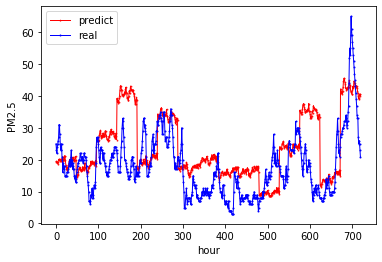

In [71]:
import matplotlib.pyplot as plt
result_dir = "D:/python_enviroments/Tensorflow_New_Enviroment/paper/论文实验部分/Result/"+city+"/predict_size_"+str(para.predict_size)+"/"
file_name = "Pure LSTM"
import matplotlib.pyplot as plt
# 连续化的对比图
final_data = main_dataset.final_data(para.validate_num)
real = final_data[para.train_size:].T[1].T
predict = list()
for index_var in range(para.validate_num):
    y = autoEncoder.predict(x=np.reshape(final_data[para.predict_size*index_var:para.predict_size*index_var+para.train_size],(-1,para.train_size,para.features)))
    y = np.reshape(y,(-1,))
    predict.append(y)
predict = np.reshape(np.array(predict),(-1,))
plt.plot(np.arange(0,len(predict)),predict,linewidth= 1,color = 'r', marker = '^',markersize=1)
plt.plot(np.arange(0,len(real)),real*data_std+data_mean,linewidth= 1,color = 'b', marker = 'o',markersize=1)
plt.xlabel('hour')
plt.ylabel('PM2.5')
plt.legend(['predict','real'])
plt.savefig(result_dir+str(para.node_size)+'/'+str(para.node_size)+ file_name+' prediction.png')
print(get_correlation(predict,real))

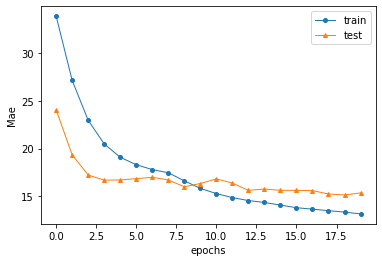

In [72]:
# 设置checkpoint  
plt.plot(np.arange(0,len(autoEncoder.history.history['loss'])),autoEncoder.history.history['loss'],marker = 'o',linewidth = 1,markersize = 4)
plt.plot(np.arange(0,len(autoEncoder.history.history['val_loss'])),autoEncoder.history.history['val_loss'],marker = '^', linewidth = 1,markersize = 4)
plt.xlabel('epochs')
plt.ylabel('Mae')
plt.legend(['train', 'test'])
plt.savefig(result_dir+str(para.node_size)+'/'+str(para.node_size)+str(para.predict_size) +' loss.png')








